In [26]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline

In [5]:
df_all = pd.read_parquet('../data/drivenow/df_all.parq')[lambda d: d['Begin Time'].dt.year > 2015]

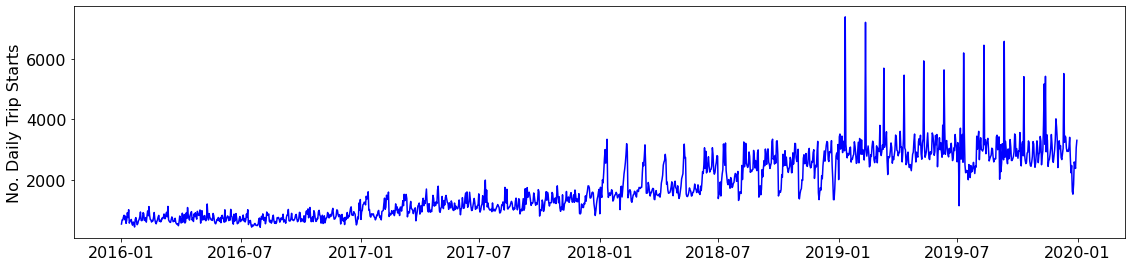

In [37]:
def plot(df):
    fig, ax = plt.subplots(figsize=(16, 4))
    plt.rcParams.update({'font.size': 16})
    ax.plot(df.assign(s=lambda d: d['Begin Time'].dt.date).groupby('s').size(), color='blue')
    ax.set_ylabel('No. Daily Trip Starts')
    plt.tight_layout()
    fig.savefig('drivenow.png', dpi=100)
    
plot(df_all)

In [23]:
def censor_by_taking_off_random_vehicles(df, seed, fraction_of_all_vehicles):
    rand_vehicles = pd.Series(df.VIN.unique()).sample(random_state=seed, frac=fraction_of_all_vehicles)
    return pd.merge(
        how='left',
        left=daily_pickups(df[~df.VIN.isin(rand_vehicles)]),
        right=daily_pickups(df),
        on='date'
    ).rename(columns={'Begin Time_x': 'y', 'Begin Time_y': 'ystar'})

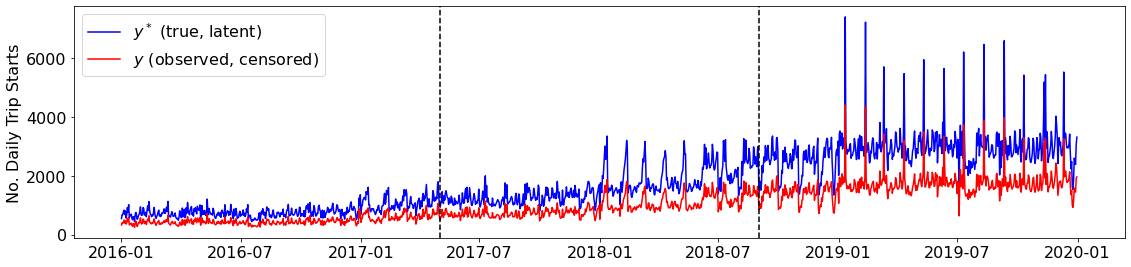

In [42]:
def daily_pickups(df):
    return df['Begin Time'].dt.date.value_counts().astype(np.float32).sort_index().reset_index().rename(columns={'index': 'date'})[lambda d: pd.to_datetime(d['date']).dt.year > 2015]

def plot_cens_example(df, seed, frac):
    df_cens = censor_by_taking_off_random_vehicles(df=df, seed=seed, fraction_of_all_vehicles=frac).set_index('date')
    fig, ax = plt.subplots(figsize=(16, 4))
    plt.rcParams.update({'font.size': 16})
    ax.plot(df_cens.ystar, color='blue', label='$y^*$ (true, latent)')
    ax.plot(df_cens.y, color='red', linestyle='-', label='$y$ (observed, censored)')
    ax.set_ylabel('No. Daily Trip Starts')
    ax.axvline(df_cens.index[len(df_cens) // 3], color='black', linestyle='--')
    ax.axvline(df_cens.index[2 * len(df_cens) // 3], color='black', linestyle='--')
    ax.legend()
    plt.tight_layout()
    fig.savefig('dncens.png', dpi=100)

plot_cens_example(df_all, 42, 0.4)